In [2]:
import torch
import time

In [6]:
model_size = 4096
seq_len = 10000

# Pure loading time

In [30]:

Key = torch.randn(seq_len,model_size)
Value = torch.randn(seq_len,model_size)
start_time = time.time()
Key = Key.to(0)
Value = Value.to(0)
torch.cuda.synchronize()
end_time = time.time()
print("Time taken to move to GPU: ", end_time - start_time)
Key = Key.to('cpu')
Value = Value.to('cpu')

Time taken to move to GPU:  0.058899879455566406


# Pure computing time

In [31]:

input = torch.randn(seq_len, model_size).to(0)
W_q = torch.randn(model_size, model_size).to(0)
W_k = torch.randn(model_size, model_size).to(0)
W_v = torch.randn(model_size, model_size).to(0)
start_time = time.time()
q = torch.matmul(input[-1], W_q)
k = torch.matmul(input, W_k)
v = torch.matmul(input, W_v)
torch.cuda.synchronize()
end_time = time.time()
print("Time taken for matmul: ", end_time - start_time)

Time taken for matmul:  0.056491851806640625


# Loading and recompute

In [49]:
model_size = 4096
compute_length = 5000
load_length = 5000
s1 = torch.cuda.Stream()
s2 = torch.cuda.Stream()
input = torch.randn(compute_length+load_length, model_size).to(0)
W_q = torch.randn(model_size, model_size).to(0)
W_k = torch.randn(model_size, model_size).to(0)
W_v = torch.randn(model_size, model_size).to(0)

K_cache = torch.randn(load_length, model_size)
V_cache = torch.randn(load_length, model_size)
start_time = time.time()
# compute
with torch.cuda.stream(s1):
    q = torch.matmul(input[-1], W_q)
    k = torch.matmul(input[:compute_length], W_k)
    v = torch.matmul(input[:compute_length], W_v)
with torch.cuda.stream(s2):
    K_cache = K_cache.to(0)
    V_cache = V_cache.to(0)
# torch.cuda.synchronize()
    K_cache = torch.cat([K_cache, k], dim=0)
    V_cache = torch.cat([V_cache, v], dim=0)
torch.cuda.synchronize()
end_time = time.time()
print("Time taken for combination: ", end_time - start_time)


Time taken for combination:  0.030561208724975586


# Generating graph

In [56]:

model_size_list = [2048,4096,8192,16384]
seq_len_list = [2000,4000,6000,8000]
batch_size = 4
time_list_compute = []
for model_size in model_size_list:
    time_list1 = []
    for seq_len in seq_len_list:
        
        input = torch.randn(batch_size,seq_len, model_size).to(0)
        W_q = torch.randn(model_size, model_size).to(0)
        W_k = torch.randn(model_size, model_size).to(0)
        W_v = torch.randn(model_size, model_size).to(0)
        start_time = time.time()
        q = torch.matmul(input[:,-1,:], W_q)
        k = torch.matmul(input, W_k)
        v = torch.matmul(input, W_v)
        torch.cuda.synchronize()
        end_time = time.time()
        time_list1.append(end_time - start_time)
    time_list_compute.append(time_list1)
print(time_list_compute)


[[0.012168169021606445, 0.022110462188720703, 0.03307390213012695, 0.04404330253601074], [0.04458951950073242, 0.08765101432800293, 0.12563276290893555, 0.14284658432006836], [0.16495513916015625, 0.32886815071105957, 0.45919370651245117, 0.6259686946868896], [0.6330480575561523, 1.2193965911865234, 1.8880023956298828, 2.544687509536743]]


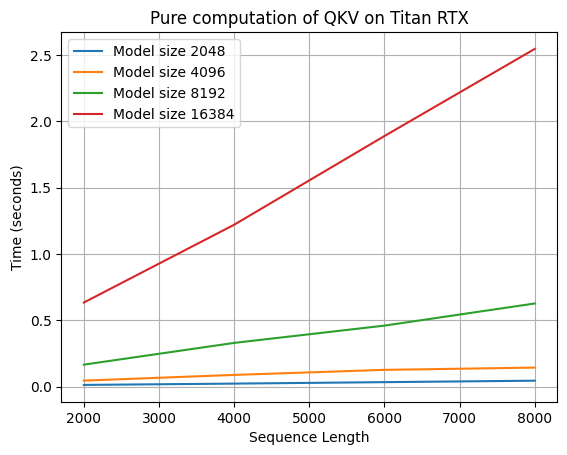

In [57]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Each model_size will be a separate line in the graph
for i, model_size in enumerate(model_size_list):
    ax.plot(seq_len_list, time_list_compute[i], label=f'Model size {model_size}')

# Label the axes and the plot
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Time (seconds)')
ax.set_title('Pure computation of QKV on Titan RTX')
ax.legend()

# Show grid for better readability
plt.grid(True)

# Displaying the graph
plt.show()

In [59]:

model_size_list = [2048,4096,8192,16384]
seq_len_list = [2000,4000,6000,8000]
batch_size = 4
time_list_load = []
for model_size in model_size_list:
    time_list1 = []
    for seq_len in seq_len_list:
        
        Key = torch.randn(batch_size,seq_len,model_size)
        Value = torch.randn(batch_size,seq_len,model_size)
        start_time = time.time()
        Key = Key.to(0)
        Value = Value.to(0)
        torch.cuda.synchronize()
        end_time = time.time()
        time_list1.append(end_time - start_time)
    time_list_load.append(time_list1)
print(time_list_load)


[[0.024138212203979492, 0.047789812088012695, 0.07066988945007324, 0.09318304061889648], [0.04789853096008301, 0.09308648109436035, 0.13723325729370117, 0.18300151824951172], [0.09304380416870117, 0.1820664405822754, 0.2702906131744385, 0.3569636344909668], [0.18237733840942383, 0.3585190773010254, 0.537665605545044, 0.7083075046539307]]


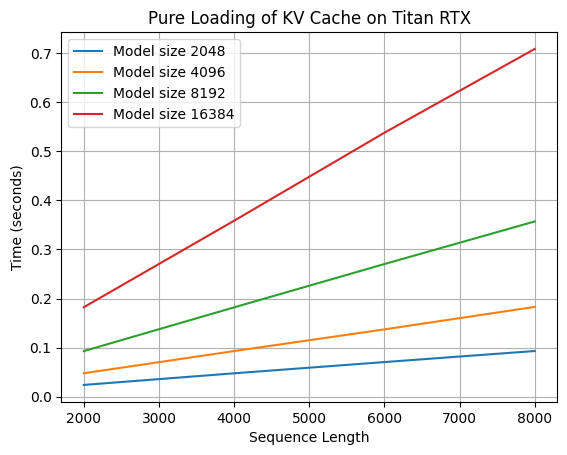

In [65]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Each model_size will be a separate line in the graph
for i, model_size in enumerate(model_size_list):
    ax.plot(seq_len_list, time_list_load[i], label=f'Model size {model_size}')

# Label the axes and the plot
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Time (seconds)')
ax.set_title('Pure Loading of KV Cache on Titan RTX')
ax.legend()

# Show grid for better readability
plt.grid(True)

# Displaying the graph
plt.show()

[[0.5041039874361685, 0.4626605802090349, 0.4680055733424198, 0.472653631427855], [0.9309162224180069, 0.9416084193702888, 0.9154687820319042, 0.7805759519727345], [1.7728761268302182, 1.8063084534376055, 1.6988888408644054, 1.7535923388373338], [3.471089462524152, 3.4012041991357536, 3.5114806975907853, 3.592631015225573]]


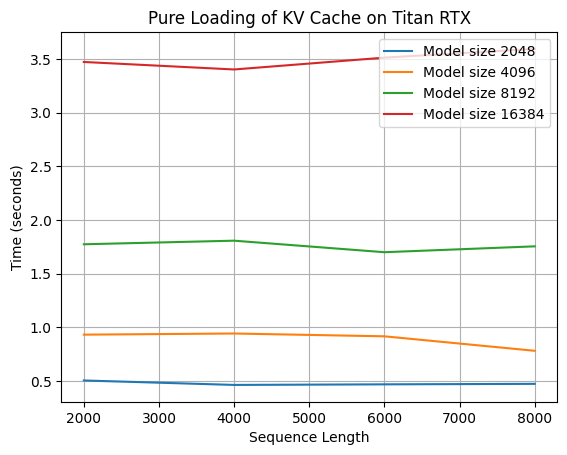

In [69]:
difference = []

for i in range(len(model_size_list)):
    difference.append([x/y for x, y in zip(time_list_compute[i], time_list_load[i])])
print(difference)
fig, ax = plt.subplots()
for i, model_size in enumerate(model_size_list):
    ax.plot(seq_len_list, difference[i], label=f'Model size {model_size}')

# Label the axes and the plot
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Time (seconds)')
ax.set_title('Pure Loading of KV Cache on Titan RTX')
ax.legend()

# Show grid for better readability
plt.grid(True)

# Displaying the graph
plt.show()
